In [1]:
import os
import re
import math
import random
import numpy as np
from scipy.stats import norm
from scipy.stats import ranksums
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # Output editable PDF text
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
microRNA = pd.read_csv('20220610_Results/1. diff_microRNA(FC2_FDR0.05).csv', index_col=0)['ID']

In [3]:
import cloudpickle as pickle
[mir2gene, GENE_LIST, GENE_MASK, gene2module, MODULE_LIST, MODULE_MASK,
 module2pathway, PATHWAY_LIST, PATHWAY_MASK] = pickle.load(open('20220610_Results/6. KEGG_MappingData.pkl', 'rb'))

/opt/conda/lib/python3.9/site-packages/torch/serialization.py:871: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at  /root/pytorch/torch/csrc/utils/tensor_numpy.cpp:68.)
  obj = cast(Storage, torch._UntypedStorage(nbytes))


In [4]:
len(microRNA), len(GENE_LIST), len(MODULE_LIST), len(PATHWAY_LIST)

(710, 11418, 116, 70)

In [6]:
import cloudpickle as pickle
[data, gene_exp, module_exp, pathway_exp, mir2gene_w, gene2module_w,
 module2pathway_w, pathway2out_w] = pickle.load( open('20220610_Results/8. Exp_and_Weight_df_test.pkl', 'rb'))

In [10]:
gene_exp['537']

GSM1878567   -0.015763
GSM1877697   -0.015763
GSM1879645   -0.015763
GSM1877269   -0.015763
GSM1879958   -0.015763
                ...   
GSM1876809   -0.015763
GSM1879670   -0.015763
GSM1878229   -0.015763
GSM1878868   -0.015763
GSM1880433   -0.015763
Name: 537, Length: 1646, dtype: float32

In [ ]:
sign = 1 if pathway2out_w[1][i]>=0 else -1
pos = pathway_exp.loc[data['Label']==1, path] * sign
neg = pathway_exp.loc[data['Label']==0, path] * sign

In [12]:
gene_exp.loc[data['Label']==0, '537'].mean()
gene_exp.loc[data['Label']==1, '537'].mean()

0.011193769

-0.015762938

In [6]:
pathway2out_w.shape

torch.Size([2, 70])

In [7]:
pathway2out_w[0][52]
pathway2out_w[0][25]
pathway2out_w[0][60]
pathway2out_w[0][14]

tensor(1.1215)

tensor(0.8884)

tensor(-0.6547)

tensor(-0.6630)

In [8]:
pathway2out_w[1][52]
pathway2out_w[1][25]
pathway2out_w[1][60]
pathway2out_w[1][14]

tensor(-1.2485)

tensor(-0.7762)

tensor(0.7032)

tensor(0.6284)

In [ ]:
 	Cell 	PID 	Pathway 	p-value 	weight 	Order
0 	52 	map01100 	Metabolic pathways 	2.439303e-211 	2.370014 	0
1 	25 	map03010 	Ribosome 	7.489215e-210 	1.664519 	1
2 	60 	map00190 	Oxidative phosphorylation 	2.585645e-208 	1.357867 	2
3 	14 	map03030 	DNA replication 	2.160983e-214 	1.291426 	3
4 	27 	map01200 	Carbon metabolism 	5.180124e-198 	1.237578 	4

In [9]:
pathway_data = pd.read_csv('Breast cancer/KEGG/pathway.txt', sep='\t')
path2name = {}
for i in pathway_data.index:
    pathway = str(pathway_data.loc[i, 'Pathway']).split('path:')[1].strip()
    name = str(pathway_data.loc[i, 'Name']).strip()
    path2name[pathway] = name
module_data = pd.read_csv('Breast cancer/KEGG/module.txt', sep='\t')
module2name = {}
for i in module_data.index:
    module = str(module_data.loc[i, 'Module']).split('md:')[1].strip()
    name = str(module_data.loc[i, 'Name']).strip()
    module2name[module] = name
gene_data = pd.read_csv('Breast cancer/KEGG/hsa.txt', sep='\t')
gene2name = {}
for i in gene_data.index:
    gene = str(gene_data.loc[i, 'Gene']).split('hsa:')[1].strip()
    name = str(gene_data.loc[i, 'Name']).strip()
    gene2name[gene] = name

In [10]:
set(data["Label"])

{0, 1}

# 1. Pathway Difference analysis

In [11]:
pathway_exp.head(1)

,map00310,map00790,map00561,map01212,map00480,map05016,map00563,map00601,map00564,map00140,...,map00190,map00020,map00061,map00130,map00532,map00280,map00680,map00515,map00350,map00330
GSM1878567,0.000309,-0.385335,-1.375007,2.678093,0.060196,0.224582,-1.189325,0.350027,0.750644,-1.075417,...,-2.218088,-1.618479,0.227646,-0.15073,1.067602,2.402193,-0.376911,0.07354,1.383809,-0.716437


('map01100', 'Metabolic pathways')

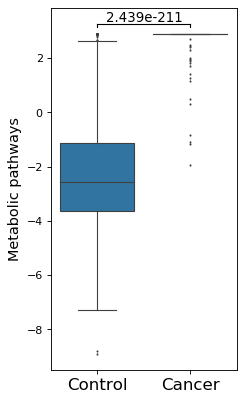

('map03010', 'Ribosome')

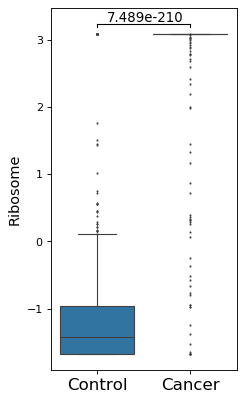

('map00190', 'Oxidative phosphorylation')

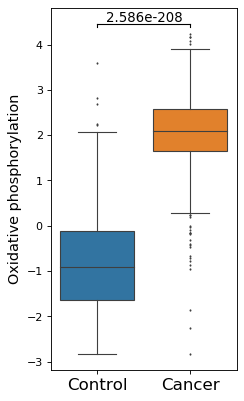

('map03030', 'DNA replication')

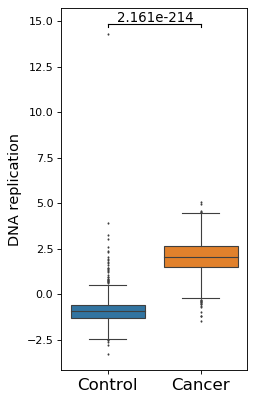

In [53]:
pw = np.abs(np.array(pathway2out_w)).sum(0)
diff_p = []
i = 0
for path in pathway_exp.columns:
    #pos = pathway_exp.loc[data['Label']=='Breast Cancer', path]
    #neg = pathway_exp.loc[data['Label']!='Breast Cancer', path]
    sign = 1 if pathway2out_w[1][i]>=0 else -1
    pos = pathway_exp.loc[data['Label']==1, path] * sign
    neg = pathway_exp.loc[data['Label']==0, path] * sign
    s, p = ranksums(pos, neg)
    #if p <= 0.05:
    diff_p.append([i, path, path2name[path], p, pw[i]])
    i += 1
#diff_p
diff_p = sorted(diff_p, key=lambda x:x[3])
diff_p = np.array(sorted(diff_p, key=lambda x:x[4], reverse=True))
#diff_p
result = pathway_exp.loc[:, diff_p[:, 1]]
result['Label'] = data['Label']
#result['Label'] = [1 if i=='Breast Cancer' else 0 for i in data['Label']]
for i, path, name, p, w in diff_p[:4]:
    sign = 1 if pathway2out_w[1][int(i)]>=0 else -1
    result[path] = sign * result[path]
    path, name
    fig = plt.figure(1, (3, 6), dpi=80)
    _ = sns.boxplot(x="Label",y=path, data=result, order=[0, 1], linewidth=1, fliersize=1)
    _ = plt.xticks([0, 1], ['Control', 'Cancer'], fontsize=15)
    _ = plt.xlabel('')
    _ = plt.ylabel(name, fontsize=13)
    
    maxy, miny = result[path].max(), result[path].min()
    dy = maxy-miny
    _ = plt.plot([0, 1], [maxy+dy*0.03, maxy+dy*0.03], lw=1., c='k')
    _ = plt.plot([0, 0], [maxy+dy*0.02, maxy+dy*0.03], lw=1., c='k')
    _ = plt.plot([1, 1], [maxy+dy*0.02, maxy+dy*0.03], lw=1., c='k')
    _ = plt.annotate(format(float(p),'.3e'), xy=(0.3, 0.96), xycoords='axes fraction', fontsize=12)
    
    #_ = plt.show()
    fig.savefig('20220610_Results/8. Pathway_'+name.split(' - ')[0]+'.pdf', dpi=300)
    _ = plt.show()

In [42]:
diff_path = pd.DataFrame(diff_p, columns=['Cell', 'PID', 'Pathway', 'p-value', 'weight'])
diff_path.to_csv('20220610_Results/8. PathwayDifference-analysis.tsv', sep='\t')

In [ ]:
diff_path = pd.read_csv('20220610_Results/8. PathwayDifference-analysis.tsv', sep='\t', index_col=0)
diff_path = diff_path.loc[diff_path['p-value']<0.05, :]
diff_path['Order'] = range(diff_path.shape[0])
diff_path.shape

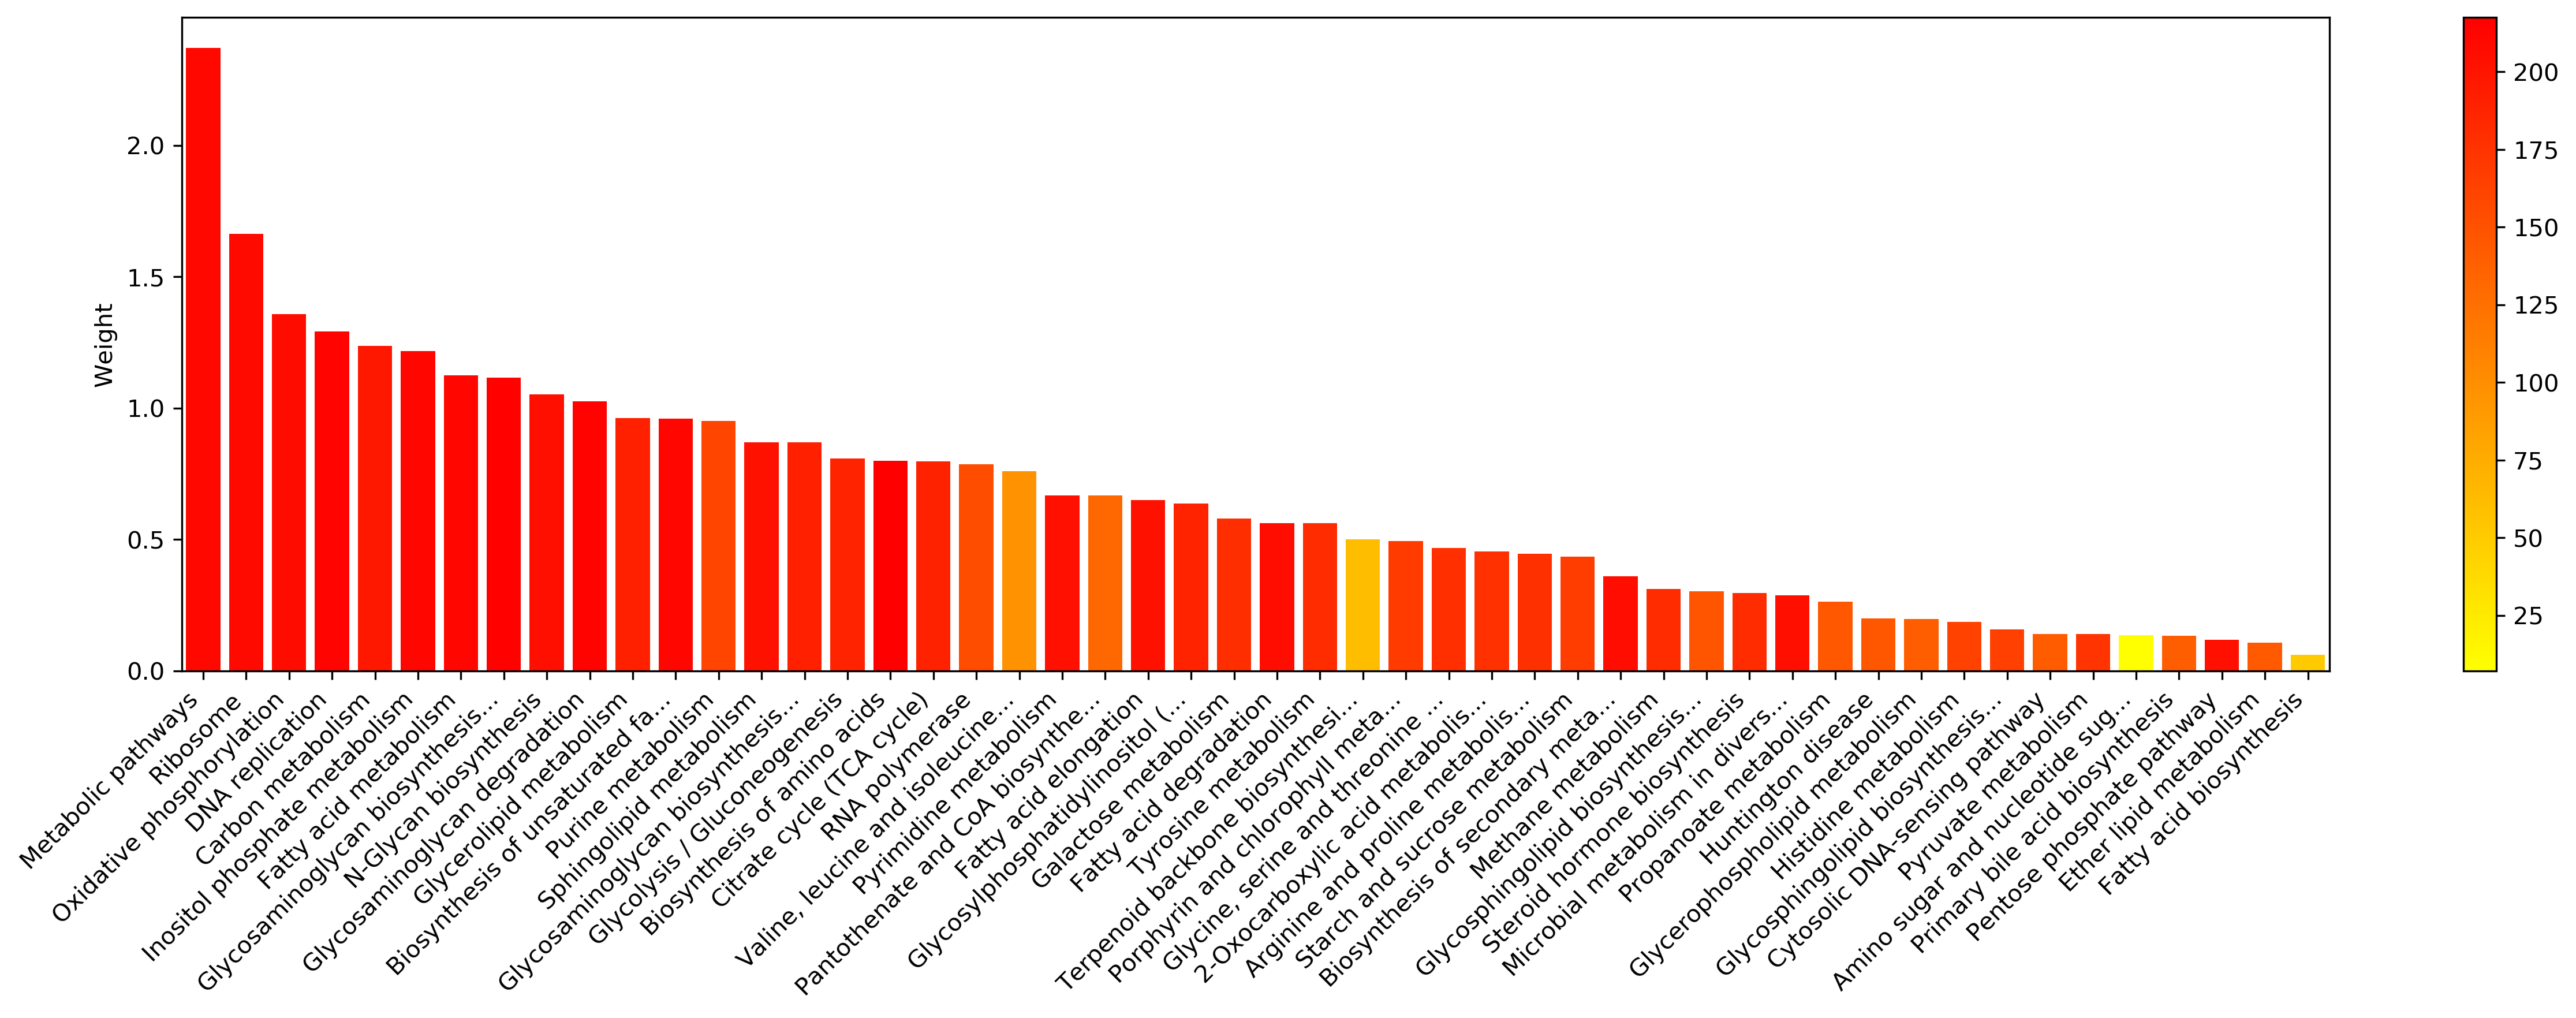

In [47]:
import matplotlib
import matplotlib.cm as cmx

cs = -np.log10(diff_path['p-value'])# Color value size 
cm = plt.get_cmap('autumn_r')
cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

fig = plt.figure(1, (20, 5), dpi=300)
colors = []
_ = plt.bar(x=diff_path['Order'], height=diff_path['weight'], width=0.8, color=scalarMap.to_rgba(cs))
_ = plt.xlim([-0.5, diff_path.shape[0]-0.5])
_ = plt.xticks(diff_path['Order'], [i[:30]+'...' if len(i)>30 else i for i in diff_path['Pathway']], 
               rotation=45, ha='right')
_ = plt.ylabel('Weight')
scalarMap.set_array(cs)
_ = fig.colorbar(scalarMap) # colorbar
_ = plt.show()
fig.savefig('20220610_Results/8. Pathway_DifferenceAnalysis-result.pdf', dpi=300)

In [48]:
diff_path.head()

,Cell,PID,Pathway,p-value,weight,Order
0,52,map01100,Metabolic pathways,2.439303e-211,2.370014,0
1,25,map03010,Ribosome,7.489215e-210,1.664519,1
2,60,map00190,Oxidative phosphorylation,2.585645e-208,1.357867,2
3,14,map03030,DNA replication,2.160983e-214,1.291426,3
4,27,map01200,Carbon metabolism,5.180124e-198,1.237578,4


# 2. Module Weight

In [132]:
def get_next_nodes(pid, weight, node_list, pw=1.0):
    scores = np.abs(np.array(weight)[pid, :])
    nodes = []
    i = 0
    for nid, score in zip(node_list, scores):
        if score>0.05:
            nodes.append([i, nid, score*pw])
        i += 1
    return nodes
    
def get_leaves_from_path(pindex, module2pathway_w, MODULE_LIST, gene2module_w, GENE_LIST, mir2gene_w, MICRORNA):
    module_nodes = sorted(get_next_nodes(pindex, module2pathway_w, MODULE_LIST, 1.0), key=lambda x:x[2], reverse=True)
    gene_nodes = {}
    for mid, _, pw in module_nodes:
        temp = get_next_nodes(mid, gene2module_w, GENE_LIST, pw)
        for gindex, gid, score in temp:
            gene_nodes[gindex] = gene_nodes.get(gindex, [gindex, gid, score])
            gene_nodes[gindex][2] += score
    gene_nodes = sorted(gene_nodes.values(), key=lambda x:x[2], reverse=True)
    micro_nodes = {}
    for gid, _, pw in gene_nodes:
        temp = get_next_nodes(gid, mir2gene_w, MICRORNA, pw)
        for mindex, mid, score in temp:
            micro_nodes[mindex] = micro_nodes.get(mindex, [mindex, mid, score])
            micro_nodes[mindex][2] += score
    micro_nodes = sorted(micro_nodes.values(), key=lambda x:x[2], reverse=True)
    return module_nodes, gene_nodes, micro_nodes

def get_network_from_path(pindex, pid, pname, pscore):
    nodes = [('Pathway_'+str(pindex), pid, pname, pscore, 30+pscore, 'Pathway')]
    links = []
    module_nodes = sorted(get_next_nodes(pindex, module2pathway_w, MODULE_LIST, 1.0), key=lambda x:x[2], reverse=True)
    gene_nodes = {}
    for mindex, mid, pw in module_nodes:
        nodes.append(['Module_'+str(mindex), mid, module2name[mid], pw, 20+pw, 'Module'])
        links.append(['Pathway_'+str(pindex), 'Module_'+str(mindex), pw])
        ### 
        temp = get_next_nodes(mindex, gene2module_w, GENE_LIST, pw)
        for gindex, gid, score in temp:
            gene_nodes[gindex] = gene_nodes.get(gindex, [gindex, gid, score])
            gene_nodes[gindex][2] += score
            links.append(['Module_'+str(mindex), 'Gene_'+str(gindex), score])
    gene_nodes = sorted(gene_nodes.values(), key=lambda x:x[2], reverse=True)
    micro_nodes = {}
    for gindex, gid, pw in gene_nodes:
        nodes.append(['Gene_'+str(gindex), gid, gene2name[gid].split(';')[0].split(',')[0].strip(), pw, 10+pw, 'Gene'])
        ###
        temp = get_next_nodes(gindex, mir2gene_w, MICRORNA, pw)
        for mindex, mid, score in temp:
            micro_nodes[mindex] = micro_nodes.get(mindex, [mindex, mid, score])
            micro_nodes[mindex][2] += score
            links.append(['Gene_'+str(gindex), 'MicroRNA_'+str(mindex), score])
    micro_nodes = sorted(micro_nodes.values(), key=lambda x:x[2], reverse=True)
    for mindex, mid, pw in micro_nodes:
        nodes.append(['MicroRNA_'+str(mindex), mid, mid, pw, pw, 'MicroRNA'])
    nodes = pd.DataFrame(nodes, columns=['NodeIndex', 'NodeID', 'NodeName', 'SumWeight', 'LevelWeight','Level'])
    links = pd.DataFrame(links, columns=['Source', 'Target', 'Weight'])
    return nodes, links

In [109]:
MICRORNA = list(data.columns)[:-1]

### Metabolic pathways(map01100, 52) contains the vast majority of MicroRNA targets (604)¶

In [110]:
module_nodes, gene_nodes, micro_nodes = get_leaves_from_path(52, module2pathway_w, MODULE_LIST, 
                                                             gene2module_w, GENE_LIST, mir2gene_w, MICRORNA)
len(module_nodes), len(gene_nodes), len(micro_nodes)

(97, 406, 604)

In [120]:
nodes, links = get_network_from_path(52, 'map01100', 'Metabolic pathways', 2.370014)
nodes.to_csv('20220610_Results/8. network_Metabolic_pathways_nodes.csv')
links.to_csv('20220610_Results/8. network_Metabolic_pathways_links.csv')

### Ribosome(map03010, 25)

In [134]:
nodes, links = get_network_from_path(25, 'map03010', 'Ribosome', 1.664519)
nodes.to_csv('20220610_Results/8. network_Ribosome_nodes.csv')
links.to_csv('20220610_Results/8. network_Ribosome_links.csv')

### Oxidative phosphorylation (map00190)

In [133]:
nodes, links = get_network_from_path(60, 'map00190', 'Oxidative phosphorylation', 1.357867)
nodes.to_csv('20220610_Results/8. network_Oxidative phosphorylation_nodes.csv')
links.to_csv('20220610_Results/8. network_Oxidative phosphorylation_links.csv')

# Redraw network

In [147]:
OP_module = np.abs(np.array(module2pathway_w)[25, :]) # Oxidative phosphorylation
mw = []
i = 0
for m, s in zip(MODULE_LIST, OP_module):
    if s>0:
        mw.append([i, m, module2name[m], s])
    i += 1
mw = sorted(mw, key=lambda x:x[3], reverse=True)
mw = pd.DataFrame(mw, columns=['Cell', 'MID', 'Module', 'Weight'])
mw.head(2)

,Cell,MID,Module,Weight
0,29,M00177,"Ribosome, eukaryotes",0.302905


In [148]:
m_gene = np.abs(np.array(gene2module_w)[29, :])
gw = []
i = 0
for g, s in zip(GENE_LIST, m_gene):
    if s>0:
        gw.append([i, g, gene2name[g], s])
    i += 1
gw = sorted(gw, key=lambda x:x[3], reverse=True)
gw = pd.DataFrame(gw, columns=['Cell', 'GID', 'Gene', 'Weight'])
gw.head(2)

,Cell,GID,Gene,Weight
0,6847,6158,"RPL28, L28; ribosomal protein L28",0.772639
1,2418,6171,"RPL41, L41; ribosomal protein L41",0.771927


In [149]:
g_mir = np.abs(np.array(mir2gene_w)[6847, :])
miw = []
i = 0
for mi, s in zip(list(data.columns)[:-1], g_mir):
    if s>0:
        miw.append([i, mi, s])
    i += 1
miw = sorted(miw, key=lambda x:x[2], reverse=True)
miw = pd.DataFrame(miw, columns=['Cell', 'MicroRNA', 'Weight'])
miw.head(2)

,Cell,MicroRNA,Weight
0,3,hsa-let-7b-3p,2.182287
1,203,hsa-miR-143-5p,0.513930


In [150]:
def getGeneMess(mcell):
    m_gene = np.abs(np.array(gene2module_w)[mcell, :])
    gw = []
    i = 0
    for g, s in zip(GENE_LIST, m_gene):
        if s>0:
            gw.append([i, g, gene2name[g], s])
        i += 1
    gw = sorted(gw, key=lambda x:x[3], reverse=True)
    gw = pd.DataFrame(gw, columns=['Cell', 'GID', 'Gene', 'Weight'])
    return gw
def getMicroRNAMess(gcell):
    g_mir = np.abs(np.array(mir2gene_w)[gcell, :])
    miw = []
    i = 0
    for mi, s in zip(list(data.columns)[:-1], g_mir):
        if s>0:
            miw.append([i, mi, s])
        i += 1
    miw = sorted(miw, key=lambda x:x[2], reverse=True)
    miw = pd.DataFrame(miw, columns=['Cell', 'MicroRNA', 'Weight'])
    return miw
    
links = []
nodes = []
pcell = 25 # Oxidative phosphorylation
pid = 'map03010'
nodes.append(['map03010', 'Ribosome', 'Pathway', 30+1.664519])
### Module
for mi in mw.index:
    mcell = mw.loc[mi, 'Cell']
    mid = mw.loc[mi, 'MID']
    name = mw.loc[mi, 'Module']
    w = mw.loc[mi, 'Weight']
    links.append([pid, mid, w])
    nodes.append([mid, name, 'Module', 20+w])
    ### Gene
    gw = getGeneMess(mcell)
    for gi in gw.index:
        gcell = gw.loc[gi, 'Cell']
        gid = gw.loc[gi, 'GID']
        name = gw.loc[gi, 'Gene'].split(';')[0].split(',')[0].strip()
        w = gw.loc[gi, 'Weight']
        links.append([mid, gid, w])
        nodes.append([gid, name, 'Gene', 10+w])
        ### MicroRNA
        miw = getMicroRNAMess(mcell)
        for mii in miw.index:
            micell = miw.loc[mii, 'Cell']
            miid = miw.loc[mii, 'MicroRNA']
            w = miw.loc[mii, 'Weight']
            links.append([gid, miid, w])
            nodes.append([miid, miid, 'MicroRNA', w])

In [151]:
links_df = pd.DataFrame(links, columns=['Target', 'Source', 'LineWeight'])
nodes_df = pd.DataFrame(nodes, columns=['NodeID', 'NodeName', 'NodeType', 'NodeWeight'])

nodes_df.to_csv('20220610_Results/8. network_Ribosome_nodes.csv')
links_df.to_csv('20220610_Results/8. network_Ribosome_links.csv')